# Análisis de Exportaciones — Data Mendez LTDA
Este notebook responde las preguntas del cliente usando los datos procesados en la arquitectura medallion (capas Silver/Gold) y añade dos análisis adicionales: concentración por empresas y tendencias por producto.

In [13]:
# Imports y configuración
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json, os
from datetime import datetime, timedelta
sns.set(style="whitegrid")
# localizar data_lake root
root = Path().resolve()
while not (root / 'data_lake').exists() and root.parent != root:
    root = root.parent
DATA_ROOT = (root / 'data_lake') if (root / 'data_lake').exists() else Path('data_lake')
print('DATA_ROOT ->', DATA_ROOT)
GOLD_DIR = DATA_ROOT / 'lake' / 'gold'
SILVER_DIR = DATA_ROOT / 'lake' / 'silver'
METADATA_DIR = DATA_ROOT / 'metadata'

def read_parquet(path):
    p = str(path)
    # 1) Try Spark (if available). If Spark raises an error, we'll fall back to arrow/pandas readers
    try:
        from pyspark.sql import SparkSession
        spark = SparkSession.builder.getOrCreate()
        df = spark.read.parquet(p)
        print('Loaded with Spark:', p)
        return df.toPandas()
    except Exception as e:
        print('Spark not available or failed, falling back to pyarrow/pandas:', e)

    # 2) Try pyarrow.dataset (robust for partitioned datasets)
    try:
        import pyarrow.dataset as ds
        ds_obj = ds.dataset(p, format='parquet')
        table = ds_obj.to_table()
        print('Loaded with pyarrow.dataset:', p)
        return table.to_pandas()
    except Exception as e:
        print('pyarrow.dataset read failed (will try pandas engines):', e)

    # 3) Try pandas.read_parquet with engine='pyarrow'
    try:
        df = pd.read_parquet(p, engine='pyarrow')
        print('Loaded with pandas (pyarrow engine):', p)
        return df
    except Exception as e:
        print('pandas.read_parquet with engine=pyarrow failed:', e)

    # 4) Try pandas.read_parquet with engine='fastparquet'
    try:
        df = pd.read_parquet(p, engine='fastparquet')
        print('Loaded with pandas (fastparquet engine):', p)
        return df
    except Exception as e:
        print('pandas.read_parquet with engine=fastparquet failed:', e)

    # If all attempts failed, raise a helpful error
    raise RuntimeError

DATA_ROOT -> /Users/mariana/Desktop/University/7/DataEngineering/final/data_lake


In [14]:
# Cargar datasets Gold (si existen)
paths = {
    'total_fob': GOLD_DIR / 'total_fob_mes',
    'top_companies': GOLD_DIR / 'top_companies_by_month',
    'top_destinations': GOLD_DIR / 'top_destinations_by_month',
    'dim_producto': GOLD_DIR / 'dim_producto'
}
dfs = {}
for k, p in paths.items():
    try:
        if p.exists():
            dfs[k] = read_parquet(str(p))
        else:
            dfs[k] = None
    except Exception as e:
        print('Failed to load', k, e)
        dfs[k] = None

for k, df in dfs.items():
    # normalize month-like columns to strings to avoid mixed dtype comparisons/sorts
    if df is not None:
        if 'ingest_month' in df.columns:
            df['ingest_month'] = pd.Series(df['ingest_month']).astype(str).str.replace(r'\.0$','', regex=True)
        if 'month' in df.columns:
            df['month'] = pd.Series(df['month']).astype(str).str.replace(r'\.0$','', regex=True)
    print(k, 'rows' if df is not None else 'not available', None if df is None else len(df))

Loaded with Spark: /Users/mariana/Desktop/University/7/DataEngineering/final/data_lake/lake/gold/total_fob_mes
Loaded with Spark: /Users/mariana/Desktop/University/7/DataEngineering/final/data_lake/lake/gold/top_companies_by_month
Loaded with Spark: /Users/mariana/Desktop/University/7/DataEngineering/final/data_lake/lake/gold/top_destinations_by_month
Loaded with Spark: /Users/mariana/Desktop/University/7/DataEngineering/final/data_lake/lake/gold/dim_producto
total_fob rows 2
top_companies rows 7332
top_destinations rows 318
dim_producto rows 3794
Loaded with Spark: /Users/mariana/Desktop/University/7/DataEngineering/final/data_lake/lake/gold/dim_producto
total_fob rows 2
top_companies rows 7332
top_destinations rows 318
dim_producto rows 3794


In [15]:
print(dfs)

{'total_fob':   ingest_month  total_fob_usd
0       202501   3.776721e+09
1       202502   3.780275e+09, 'top_companies':      nit_exportador                       razon_social_exportador  \
0       899999068.0                                 ECOPETROL S A   
1       800021308.0                                  DRUMMOND LTD   
2       860007538.0  FEDERACION NACIONAL DE CAFETEROS DE COLOMBIA   
3       900166687.0    CONTINENTAL GOLD LIMITED SUCURSAL COLOMBIA   
4       860069804.0                 CARBONES DEL CERREJON LIMITED   
...             ...                                           ...   
7327    901848330.0                        COLOMBIAN BLOOMS S.A.S   
7328    901055763.0                         CRISTAL GARDENS S.A.S   
7329    901666386.0                                GROWING CO SAS   
7330    900412954.0                       FLORES SAN MIGUEL S.A.S   
7331    901202636.0                               IWA FLOWERS SAS   

         total_fob ingest_month  
0     6.843816e

## 1) ¿Qué empresas más exportaron en el último mes?
Utilizamos la tabla `top_companies_by_month` (Gold).

Último mes detectado: 202502
Showing top rows for the latest month: 202502


,company_label,total_fob
0,ECOPETROL S A,6.843816e+08
1,DRUMMOND LTD,2.040233e+08
2,FEDERACION NACIONAL DE CAFETEROS DE COLOMBIA,1.087549e+08
3,CONTINENTAL GOLD LIMITED SUCURSAL COLOMBIA,7.609892e+07
4,CARBONES DEL CERREJON LIMITED,7.317356e+07
5,FRONTERA ENERGY COLOMBIA CORP SUCURSAL COLOMBIA,7.243016e+07
6,ARIS MINING SEGOVIA,5.418087e+07
7,C.I. PRODECO S.A.,4.508592e+07
8,COMERCIALIZADORA INTERNACIONAL ESLOP SAS,4.491424e+07
9,XM COMPAÑIA DE EXPERTOS EN MERCADOS S.A. E.S.P.,4.347517e+07


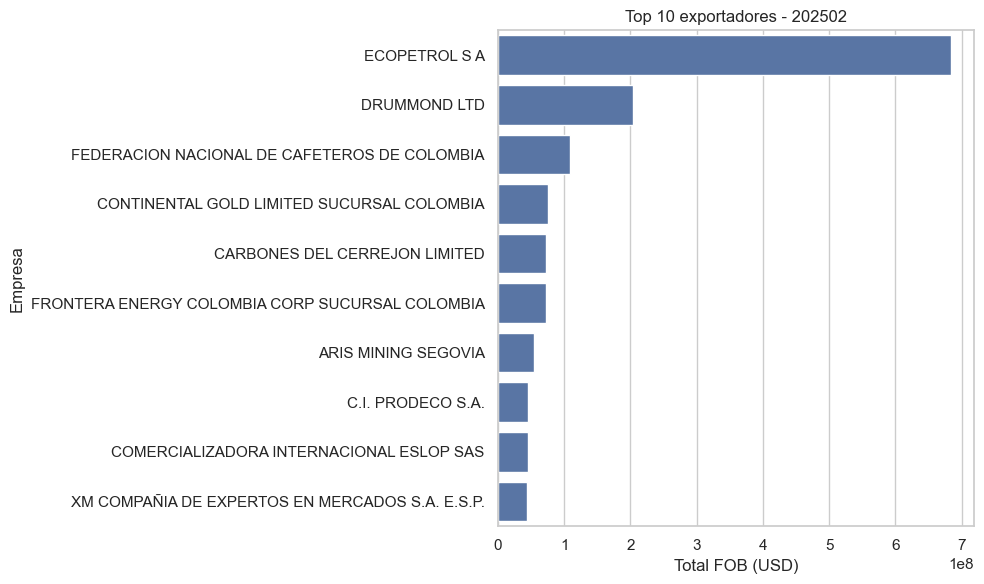

In [16]:
def latest_month_from_dfs(dfs):
    # Collect candidate month values from available dataframes and normalize to strings (YYYYMM)
    cand = []
    for k in ['total_fob', 'top_companies', 'top_destinations']:
        df = dfs.get(k)
        if df is None:
            continue
        if 'ingest_month' in df.columns:
            cand += list(df['ingest_month'].dropna().astype(str).tolist())
        elif 'month' in df.columns:
            cand += list(df['month'].dropna().astype(str).tolist())
    # normalize numeric-like strings (remove trailing .0) and ensure uniqueness
    import re, pandas as _pd
    norm = []
    for v in cand:
        if v is None or (isinstance(v, float) and _pd.isna(v)):
            continue
        s = str(v).strip()
        # remove trailing .0 from numeric representations (e.g., '202501.0')
        s = re.sub(r'\.0+$', '', s)
        norm.append(s)
    norm = sorted(set(norm))
    if not norm:
        return None
    # return the latest by lexical order (YYYYMM strings sort correctly)
    return norm[-1]

latest_month = latest_month_from_dfs(dfs)
print('Último mes detectado:', latest_month)

# Improved top companies display: prefer razon_social_exportador, fallback to nit_exportador (formatted), ensure numeric sorting
company_name_candidates = [
    'razon_social_exportador', 'razon_social', 'empresa', 'empresa_nombre',
    'razon_social_exportadora', 'nombre_exportador'
]

if dfs.get('top_companies') is not None and latest_month is not None:
    t = dfs['top_companies'].copy()
    # normalize ingest_month in this df to string (remove .0 if present) and filter
    t['ingest_month'] = t['ingest_month'].astype(str).str.replace(r'\.0$','', regex=True)
    df_last = t[t['ingest_month'] == str(latest_month)].copy()

    # determine total_fob column (priority list)
    total_col = None
    for c in ['total_fob', 'total_fob_usd', 'total_fob_usd_total']:
        if c in df_last.columns:
            total_col = c
            break
    if total_col is None:
        # try find any numeric column
        numeric_cols = df_last.select_dtypes(include=['number']).columns.tolist()
        total_col = numeric_cols[0] if numeric_cols else None

    # determine company label column
    company_col = None
    for c in company_name_candidates:
        if c in df_last.columns:
            company_col = c
            break
    # fallback to nit_exportador if no razon_social-like column found
    if company_col is None and 'nit_exportador' in df_last.columns:
        company_col = 'nit_exportador'

    # create display label: format NIT as integer-like string when used
    if company_col == 'nit_exportador':
        def fmt_nit(x):
            try:
                if pd.isna(x):
                    return 'sin_nit'
                # avoid scientific notation or trailing .0
                xf = float(x)
                if xf.is_integer():
                    return str(int(xf))
                return str(xf)
            except Exception:
                return str(x)
        df_last['company_label'] = df_last['nit_exportador'].apply(fmt_nit)
    elif company_col is not None:
        df_last['company_label'] = df_last[company_col].fillna('sin_nombre').astype(str)
    else:
        df_last['company_label'] = 'sin_nombre'

    # ensure total_col is numeric for sorting/plotting
    if total_col is not None:
        df_last[total_col] = pd.to_numeric(df_last[total_col], errors='coerce').fillna(0)

    # display a small table and a bar chart of top-10
    disp_cols = ['company_label'] + ([total_col] if total_col is not None else [])
    print('Showing top rows for the latest month:', latest_month)
    display(df_last[disp_cols].head(10))

    if total_col is not None:
        top10 = df_last.sort_values(total_col, ascending=False).head(10).copy()
        plt.figure(figsize=(10,6))
        sns.barplot(data=top10, x=total_col, y='company_label')
        plt.title(f'Top 10 exportadores - {latest_month}')
        plt.xlabel('Total FOB (USD)')
        plt.ylabel('Empresa')
        plt.tight_layout()
    else:
        print('No se encontró columna de valor total para ordenar.')
else:
    print('top_companies no disponible; necesitaríamos calcularlo desde Silver o cargar el parquet correspondiente')

**Conclusión — Top exportadores (último mes)**
- El último mes detectado es 202502. El principal exportador es ECOPETROL S A con ~684M USD (≈18% del total del mes).
- Hay una alta concentración en pocas empresas; el top-3 representa ~26–27% del total.
- Recomendación: monitorear la dependencia de las exportaciones en estas empresas y validar outliers en los datos.